<a href="https://colab.research.google.com/github/Hira63S/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/Hira_LS_DS_242_Review_and_Regularization_LIVE_LEESON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Review & Regularization

## Start with example solution for yesterday's assignment

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.

def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [0]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [0]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [0]:
# Download and join data into a dataframe
data = load()

#### `SNOW` and `AWND` have minimums of `-9999` ...

In [10]:
data.describe(include='number')

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


### Clean data and engineer features

In [0]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [0]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

### RandomizedSearchCV review / SPRINT CHALLENGE PRACTICE
- https://twitter.com/jakevdp/status/648593367786323968
- https://www.google.com/search?q=site%3Ascikit-learn.org+RandomizedSearchCV
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
- https://www.google.com/search?q=XGBRegressor
  - https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://www.google.com/search?q=xgboost+parameter+tuning
  - https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
- https://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb

In [0]:
# TODO

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint

In [0]:
param_distributions = {
    'n_estimators': randint(50,500),
    'max_depth': randint(1,5)
    
}

search = RandomizedSearchCV(
    estimator = XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_distributions, #find active hyperparameteres
    n_iter = 50,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv = 3,
    verbose = 10,
    return_train_score=True
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f54f2b3f6a0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f54f2b3f7f0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [0]:
search.best_score_

-266.5094070949535

In [0]:
print('Mean Absolute Error with Cross-Validation')
print(f'Error of {-search.best_score_} bicyclists per day, on average')

Mean Absolute Error with Cross-Validation
Error of 266.5094070949535 bicyclists per day, on average


In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
26,0.288573,0.014907,0.008229,0.003245,2,227,"{'max_depth': 2, 'n_estimators': 227}",-240.651053,-303.838372,-255.038797,-266.509407,27.041209,1,-177.601324,-169.054479,-174.584153,-173.746652,3.539133
7,0.278801,0.009001,0.005830,0.000135,2,226,"{'max_depth': 2, 'n_estimators': 226}",-240.765223,-304.056676,-255.097206,-266.639702,27.097034,2,-177.697899,-169.226998,-174.692333,-173.872410,3.506494
16,0.205871,0.001663,0.005281,0.000092,3,120,"{'max_depth': 3, 'n_estimators': 120}",-243.247426,-304.436923,-254.365299,-267.349883,26.614385,3,-155.754275,-149.467524,-155.145668,-153.455822,2.831077
12,0.209288,0.008530,0.005215,0.000111,3,119,"{'max_depth': 3, 'n_estimators': 119}",-243.155651,-304.877402,-254.307524,-267.446859,26.856101,4,-155.927031,-150.035734,-155.655137,-153.872634,2.715368
25,0.334482,0.004906,0.006655,0.000602,2,278,"{'max_depth': 2, 'n_estimators': 278}",-240.107017,-303.100526,-259.450114,-267.552552,26.347456,5,-168.006304,-158.061455,-163.916793,-163.328184,4.081246
11,0.354321,0.010954,0.006405,0.000148,2,290,"{'max_depth': 2, 'n_estimators': 290}",-242.003276,-303.234089,-258.998019,-268.078462,25.808835,6,-166.216300,-155.923752,-161.934967,-161.358340,4.221652
45,0.338396,0.007125,0.006488,0.000131,4,158,"{'max_depth': 4, 'n_estimators': 158}",-251.068274,-302.357840,-251.449856,-268.291990,24.088698,7,-87.602071,-85.626237,-87.149742,-86.792683,0.845221
37,0.520762,0.009091,0.007843,0.000270,2,428,"{'max_depth': 2, 'n_estimators': 428}",-239.340969,-306.676802,-261.061882,-269.026551,28.060715,8,-146.596470,-133.141072,-139.347723,-139.695088,5.498632
22,0.293338,0.002855,0.005924,0.000265,3,171,"{'max_depth': 3, 'n_estimators': 171}",-245.110404,-307.535504,-254.496243,-269.047384,27.483632,9,-132.673931,-130.636762,-134.051616,-132.454103,1.402747
5,0.297605,0.008703,0.006053,0.000164,3,170,"{'max_depth': 3, 'n_estimators': 170}",-245.258800,-307.228102,-254.702206,-269.063036,27.260762,10,-133.154139,-131.024925,-134.542084,-132.907049,1.446465


In [0]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=227, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

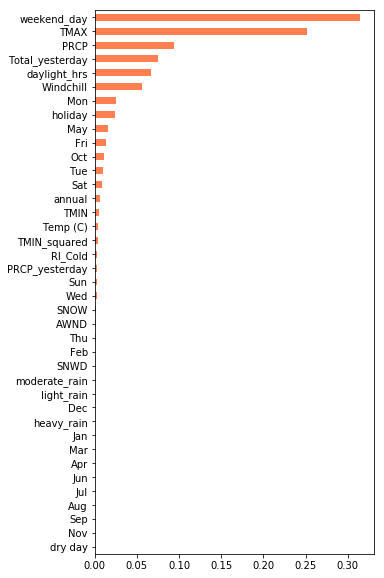

In [0]:
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='coral');

In [0]:
from sklearn.metrics import mean_absolute_error

final  = search.best_estimator_
y_pred = final.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error', test_mae)

Mean Absolute Error 229.43784423828126


### Take the last step

Yesterday's assingment said,

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

In [0]:
# TODO
y_train.describe()

count     963.000000
mean     2534.329180
std      1224.065027
min        98.000000
25%      1755.000000
50%      2381.000000
75%      3317.500000
max      6088.000000
Name: Total, dtype: float64

In [0]:
from sklearn.metrics import mean_absolute_error

final  = search.best_estimator_
y_pred = final.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error', test_mae)

Mean Absolute Error 229.43784423828126


## A few new things!
- Pipeline + RandomizedSearchCV
- SelectKBest for feature selection, in a pipeline
- Ridge Regression, a linear model with regularization

In [0]:
# TODO
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import f_regression, SelectKBest

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(f_regression), #select the k best targets that are more related with target
    Ridge() #ridge regression

)

param_distributions = {
    #SelectKBest k parameters
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
    
}

In [35]:
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions = param_distributions,
    n_iter=120,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score = True,
    random_state=42
)
    

search.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 117 is smaller than n_iter=120. Running 117 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0613s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s


Fitting 3 folds for each of 117 candidates, totalling 351 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 351 out of 351 | elapsed:   11.7s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_regression at 0x7fb65c133f28>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
          fit_params=None, iid='warn', n_iter=120, n_jobs=-1,
          param_distributions={'selectkbest__k': range(1, 40), 'ridge__alpha': [0.1, 1.0, 10.0]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [36]:
print("mean absolute error w/ cross-val", -search.best_score_)

mean absolute error w/ cross-val 295.1047454139151


In [37]:
# Shows which features were selected
selector = search.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n', 'Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Sat
Sun
holiday
daylight_hrs
Temp (C)
dry day
annual
PRCP_yesterday
Windchill
Rl_Cold
TMIN_squared
Jan
Feb
Mar
May
Jun
Jul
Aug
Nov
Dec
light_rain
moderate_rain
heavy_rain
weekend_day

 Features not selected:
SNOW
SNWD
Fri
Apr
Sep
Oct


In [38]:
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions = param_distributions,
    n_iter=150,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=4,
    verbose=10,
    return_train_score = True,
    random_state=42
)
    

search.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 117 is smaller than n_iter=150. Running 117 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0720s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s


Fitting 4 folds for each of 117 candidates, totalling 468 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 468 out of 468 | elapsed:   18.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_regression at 0x7fb65c133f28>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
          fit_params=None, iid='warn', n_iter=150, n_jobs=-1,
          param_distributions={'selectkbest__k': range(1, 40), 'ridge__alpha': [0.1, 1.0, 10.0]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [39]:
# Shows which features were selected
selector = search.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n', 'Features not selected:')
for name in unselected_names:
    print(name)
    

Features selected:
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Sat
Sun
holiday
daylight_hrs
Temp (C)
dry day
annual
PRCP_yesterday
Windchill
Rl_Cold
TMIN_squared
Jan
Feb
Mar
May
Jun
Jul
Aug
Nov
Dec
light_rain
moderate_rain
heavy_rain
weekend_day

 Features not selected:
SNOW
SNWD
Fri
Apr
Sep
Oct


## Regularization with Linear Models

- https://www.google.com/search?q=site%3Ascikit-learn.org+regularization+%22linear+models%22
  - https://scikit-learn.org/stable/modules/linear_model.html
  - https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
  - https://scikit-learn.org/stable/modules/linear_model.html#lasso
  - https://scikit-learn.org/stable/modules/linear_model.html#setting-regularization-parameter
  - https://scikit-learn.org/stable/modules/linear_model.html#using-cross-validation
    
> The [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 
  
> The `alpha` parameter controls the degree of sparsity of the estimated coefficients.
  
> scikit-learn exposes objects that set the Lasso `alpha` parameter by cross-validation: [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) ...

In [40]:
from ipywidgets import interact
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def plot_lasso_coefs(power=-2):
    # Make pipeline with StandardScaler and Lasso Linear Model
    alpha = 10**power
    print(f'Lasso Alpha: {alpha}')
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=100000))
    
    # Get cross-validation scores
    maes = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)
    print('Cross-Validated Mean Absolute Error:', maes.mean())
    
    # Get coefficients
    pipe.fit(X_train, y_train)
    coefficients = pd.Series(pipe.named_steps['lasso'].coef_, X_train.columns)
    
    # Plot coefficients
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-550,550)

interact(plot_lasso_coefs, power=(-2,2,1));

interactive(children=(IntSlider(value=-2, description='power', max=2, min=-2), Output()), _dom_classes=('widge…

Increasing the power makes the coefficients disappear. 
as the power gets high, we only use a fewer of features. 

In [0]:
from sklearn.linear_model import LassoCV

pipe = make_pipeline(StandardScaler(), LassoCV(cv=5))
pipe.fit(X_train, y_train)
lasso = pipe.named_steps['lassocv']
print('Lasso Linear Model, alpha value optimized with cross validation:', lasso.alpha_)

Lasso Linear Model, alpha value optimized with cross validation: 4.8460094463567644


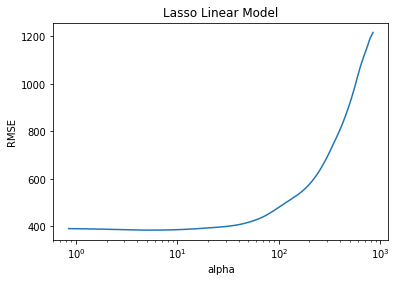

In [0]:
alphas = lasso.alphas_
mses = lasso.mse_path_.mean(axis=1)
rmses = np.sqrt(mses)
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xscale('log');

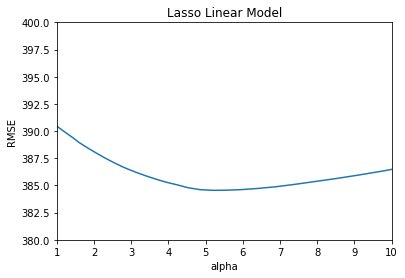

In [0]:
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xlim(1,10)
plt.ylim(380,400);

## Want to learn more about regularized linear models?
- Aaron Gallant, [Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) (9 minute video)
- Selecting good features, [Part 2](https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/) and [Part 4](https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapters 3 & 6

In [15]:
param_distributions = {
    'n_estimators': randint(50,500),
    'max_depth': randint(1,5)
    
}

search = RandomizedSearchCV(
    estimator = XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_distributions, #find active hyperparameteres
    n_iter = 50,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv = 5,
    verbose = 10,
    return_train_score=True
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb667ddc7b8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb667ddc908>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

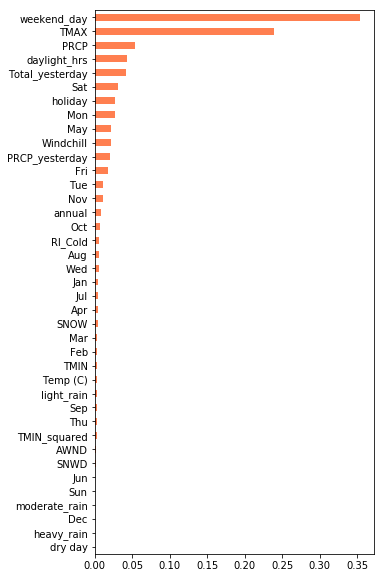

In [16]:
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='coral');

In [17]:
from sklearn.metrics import mean_absolute_error

final  = search.best_estimator_
y_pred = final.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error', test_mae)

Mean Absolute Error 254.48682556152343


In [29]:
X_train.columns.tolist()

['PRCP',
 'SNOW',
 'SNWD',
 'TMAX',
 'TMIN',
 'AWND',
 'Total_yesterday',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'holiday',
 'daylight_hrs',
 'Temp (C)',
 'dry day',
 'annual',
 'PRCP_yesterday',
 'Windchill',
 'Rl_Cold',
 'TMIN_squared',
 'Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec',
 'light_rain',
 'moderate_rain',
 'heavy_rain',
 'weekend_day']

In [0]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns=['PRCP',
 'SNOW',
 'SNWD',
 'TMAX',
 'TMIN',
 'AWND',
 'Total_yesterday',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'holiday',
 'daylight_hrs',
 'Temp (C)',
 'dry day',
 'annual',
 'PRCP_yesterday',
 'Windchill',
 'Rl_Cold',
 'TMIN_squared',
 'Jan',
 'Feb',
 'Mar',
 'Nov',
 'Dec',
 'light_rain',
 'moderate_rain',
 'heavy_rain',
 'weekend_day','Total'])
    y_train = train.Total

    X_test  = test.drop(columns=['PRCP',
 'SNOW',
 'SNWD',
 'TMAX',
 'TMIN',
 'AWND',
 'Total_yesterday',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'holiday',
 'daylight_hrs',
 'Temp (C)',
 'dry day',
 'annual',
 'PRCP_yesterday',
 'Windchill',
 'Rl_Cold',
 'TMIN_squared',
 'Jan',
 'Feb',
 'Mar',
 'Nov',
 'Dec',
 'light_rain',
 'moderate_rain',
 'heavy_rain',
 'weekend_day','Total'])
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

To avoid overfitting: ridge regression

- Ordinary Least Squares (Linaer Regressions) minimizes the sum of squared error
- when there are too mnay features, the predictions might be great but predictive power is poor.


regularization makes the coefficients cost something. Trying to optimize the fit and the cost of the coefficients gives the regularization models.

-least squares does what it does the best. Gives the best estimate with minimum error relative to mean.

Bia vs. variance trade off.
variance is sensitive of the training data-so overfits
bias-doesn't recognize relations between features and output-underfits

Regularization adds bias to reduce variance.

L2 Regularization: minimum teh squared error plus the sum of squared coefficients. Model doesn't wants large coefficents and gives flatter results. 

Ridge regression gives generalized lambda.